In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read csv w/out header
data = pd.read_csv('../data/2021-10-19_2022-01-09_CF2.csv', header=None, low_memory=False
                   )

# Forward fill the header name for each PowerScout
data.iloc[0] = data.T[0].fillna(method='ffill')

# Rename the 'nan' block
data.loc[0, 0] = 'Timestamp'

# Create the multi-index
data.columns = [list(data.iloc[0]), list(data.iloc[1])]

# Drop the first two rows because they're just the column names, and any column with only nulls
data = data[2:]

# Convert timestamp column to datetime format
data.Timestamp = pd.to_datetime(
    data.Timestamp.Timestamp, infer_datetime_format=True)

# Set Timestamp column as index, set columns to type 'float', rename index
data = data.set_index([('Timestamp', 'Timestamp')]
                      ).replace('-', np.nan).astype(float)
data.index.rename('Timestamp', inplace=True)

# Drop any column or row with all nulls
data = data.dropna(how='all', axis=1).dropna(how='all', axis=0)

# remove noise (zeros) from the data
data = data.replace(0, np.nan).fillna(method='ffill')


In [3]:
# Slice to the two power systems we're monitoring and rename columns
building_cols = ['PowerScout DPS126', 'PowerScout DPS121']
building_gross = data[building_cols].rename(
    columns={'PowerScout DPS126': 'solar', 'PowerScout DPS121': 'usage'}
)

# Create our separate y-columns: solar pwr generated, buildling pwr used
idx = pd.IndexSlice

# Create DF with only Energy, resample hourly - keep just the last value (meter readings)
gross_energy = building_gross.loc[idx[:], idx[:, 'Total Energy (kWh)']]

# reset gross_energy starting point (last line in the csv is the first timestamp)
gross_energy = gross_energy - gross_energy.iloc[-1,:]

# Create DF with only Power, resample hourly by summing
gross_power = building_gross.loc[idx[:], idx[:, 'True Power (kW)']]


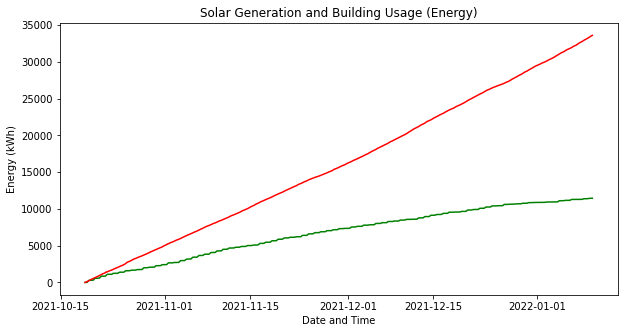

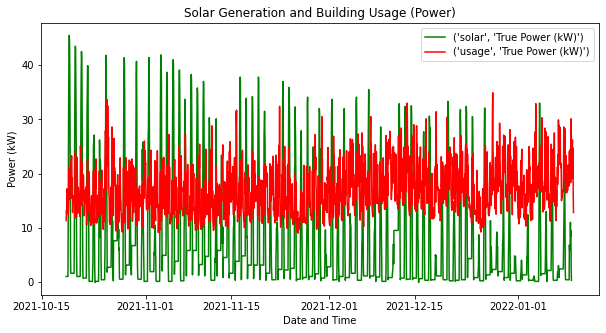

In [4]:
# Plot Energy - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Solar Generation and Building Usage (Energy)')

ax.plot(gross_energy.solar, color='g')
ax.plot(gross_energy.usage, color='r')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Energy (kWh)')
plt.show()

# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Solar Generation and Building Usage (Power)')

ax.plot(gross_power.solar, color='g')
ax.plot(gross_power.usage, color='r')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Power (kW)')
plt.legend(gross_power.columns)
plt.show()

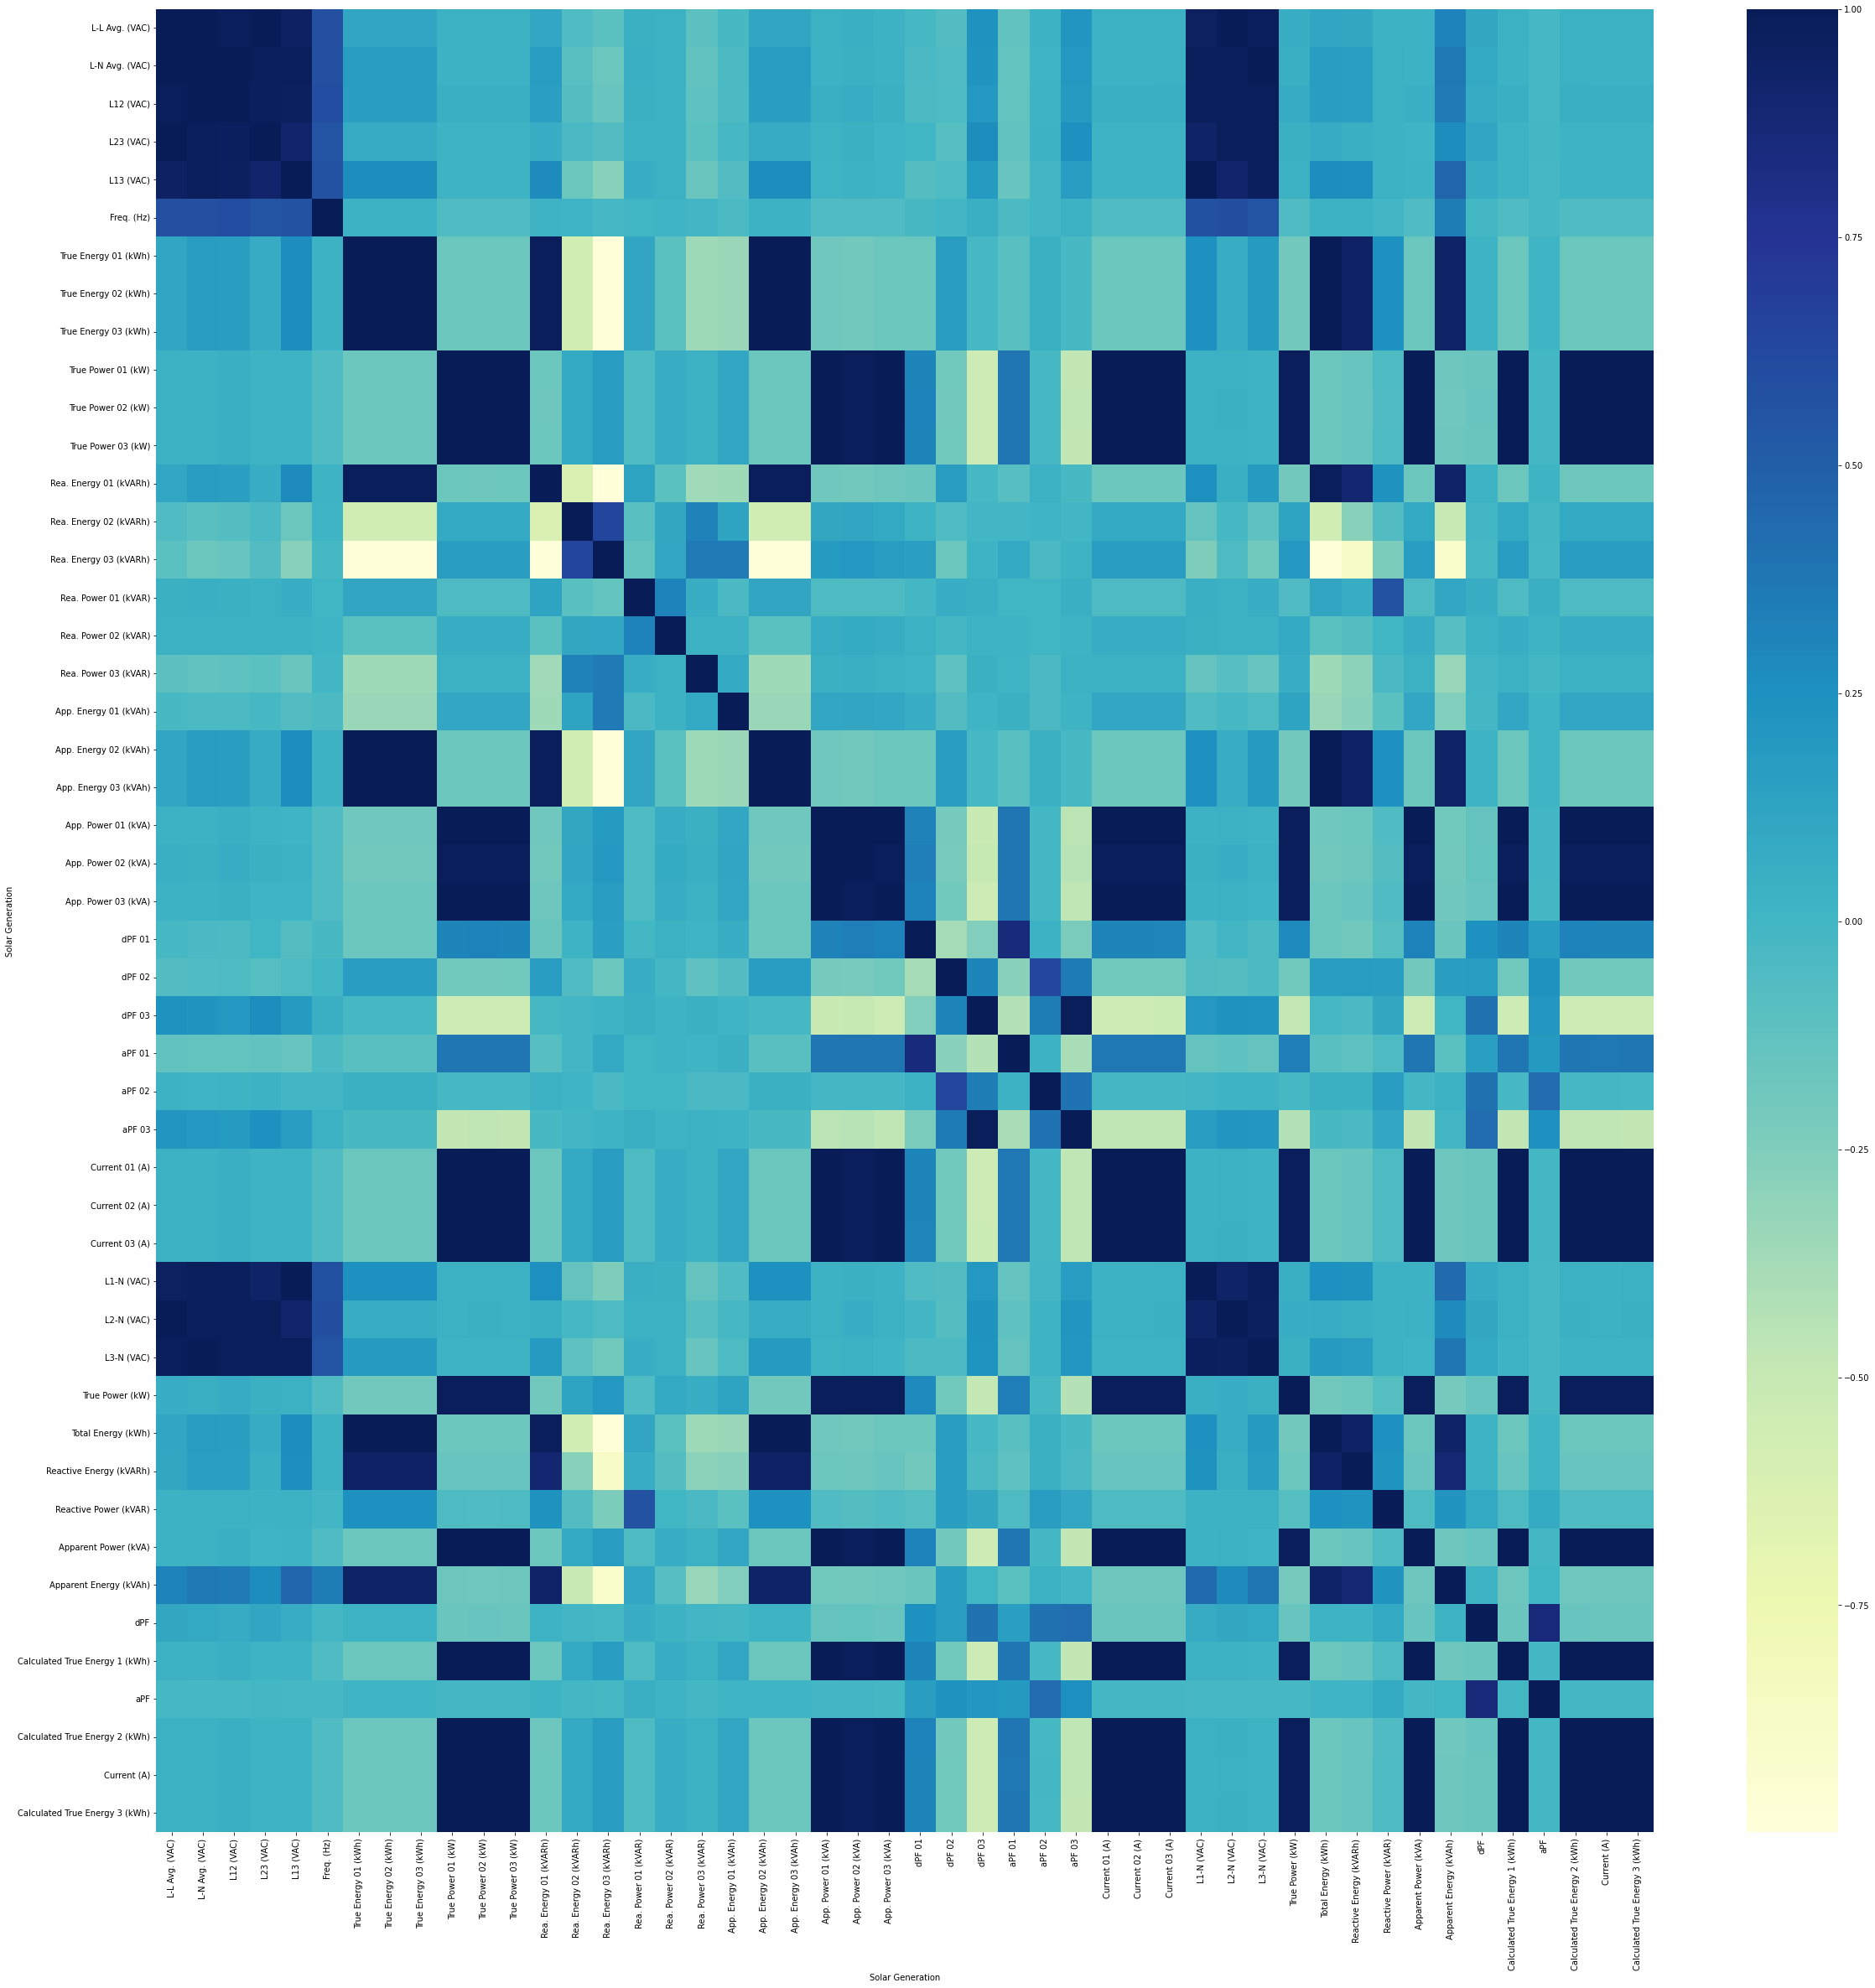

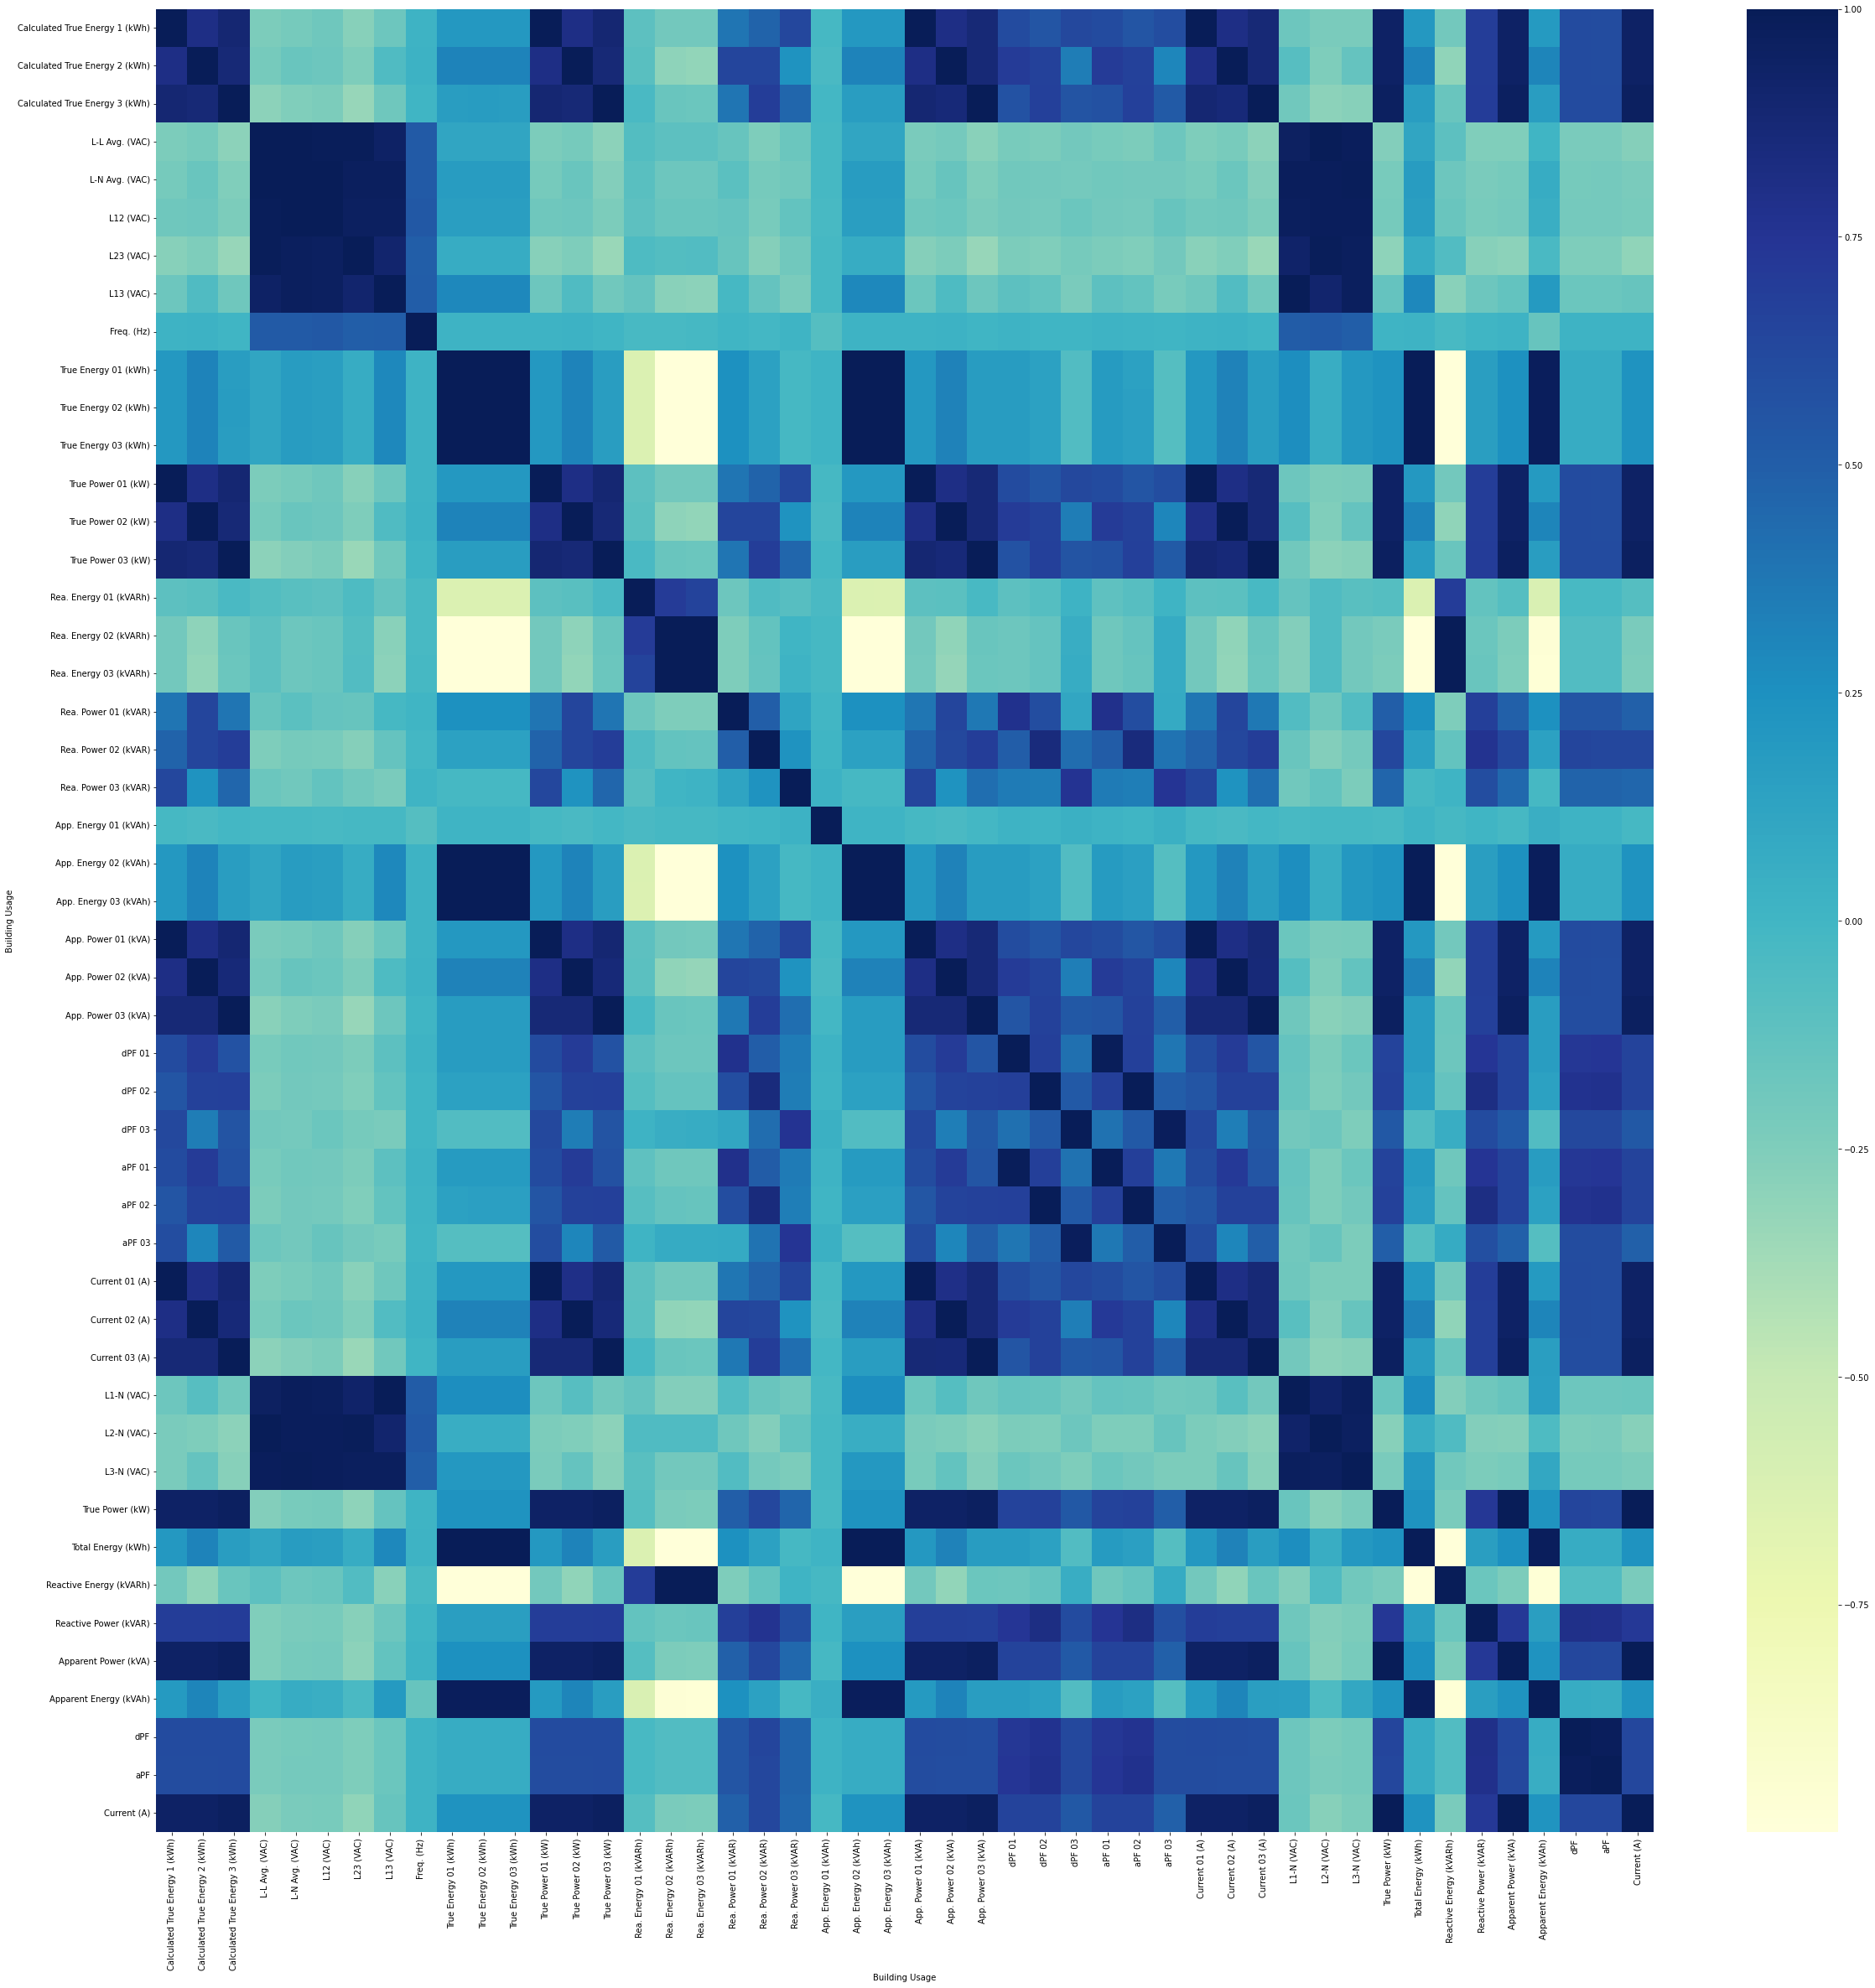

In [5]:
# Correlation Matrices - Solar and Build

# Solar Corr Matrix
plt.figure(figsize=(40, 40))
hm = sns.heatmap(building_gross.solar.corr(), cmap='YlGnBu')
hm.set(xlabel='Solar Generation'
       ,ylabel='Solar Generation'
      )

# Building Usage Corr Matrix
plt.figure(figsize=(40, 40))
hm = sns.heatmap(building_gross.usage.corr(), cmap='YlGnBu')
hm.set(xlabel='Building Usage'
       ,ylabel='Building Usage'
      )
plt.show()

In [6]:
# Cross correlation between Solar and Building Usage
building_gross.solar.corrwith(building_gross.usage)

L-L Avg. (VAC)                    0.980391
L-N Avg. (VAC)                    0.979524
L12 (VAC)                         0.979036
L23 (VAC)                         0.982082
L13 (VAC)                         0.980867
Freq. (Hz)                        0.891276
True Energy 01 (kWh)              0.987565
True Energy 02 (kWh)              0.986797
True Energy 03 (kWh)              0.987719
True Power 01 (kW)                0.020250
True Power 02 (kW)               -0.018021
True Power 03 (kW)                0.074409
Rea. Energy 01 (kVARh)           -0.647891
Rea. Energy 02 (kVARh)            0.585559
Rea. Energy 03 (kVARh)            0.998018
Rea. Power 01 (kVAR)              0.046062
Rea. Power 02 (kVAR)             -0.022444
Rea. Power 03 (kVAR)             -0.064423
App. Energy 01 (kVAh)            -0.046980
App. Energy 02 (kVAh)             0.986564
App. Energy 03 (kVAh)             0.987686
App. Power 01 (kVA)              -0.004319
App. Power 02 (kVA)              -0.055665
App. Power 

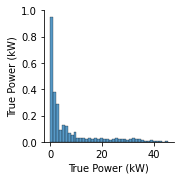

In [7]:
sns.pairplot(gross_power.solar)